In [269]:
import numpy as np
import matplotlib.pyplot as plt
import imageio
import cv2
import torch
import torchvision.transforms as transforms

from gel_tools.band_detection import watershed_seg
from segmentation.unet import UNet
from segmentation.evaluation.basic_eval import evaluate
from segmentation.helper_functions.data_functions import prep_dataloader

In [9]:
selected_file = "C:/2022_Summer_Intern/Gel_Images_UNet_Test/Models/PC_Gel_Nathan_Q1+Q2+selected_2022_07_28_16;42;07/segmentation_images/epoch1_mask_pred.npy"

In [101]:
selected_file = "C:/Users/s2137314/Downloads/epoch160_mask_pred.npy"

In [102]:
# mask_pred = cv2.imread()  # H, W, C

In [103]:


data = np.load(selected_file)
height = int(data.shape[0])
width = int(data.shape[1])
print(data.shape)

(1024, 1360, 2)


In [104]:
# Thresholding

# Threshold Comparisons

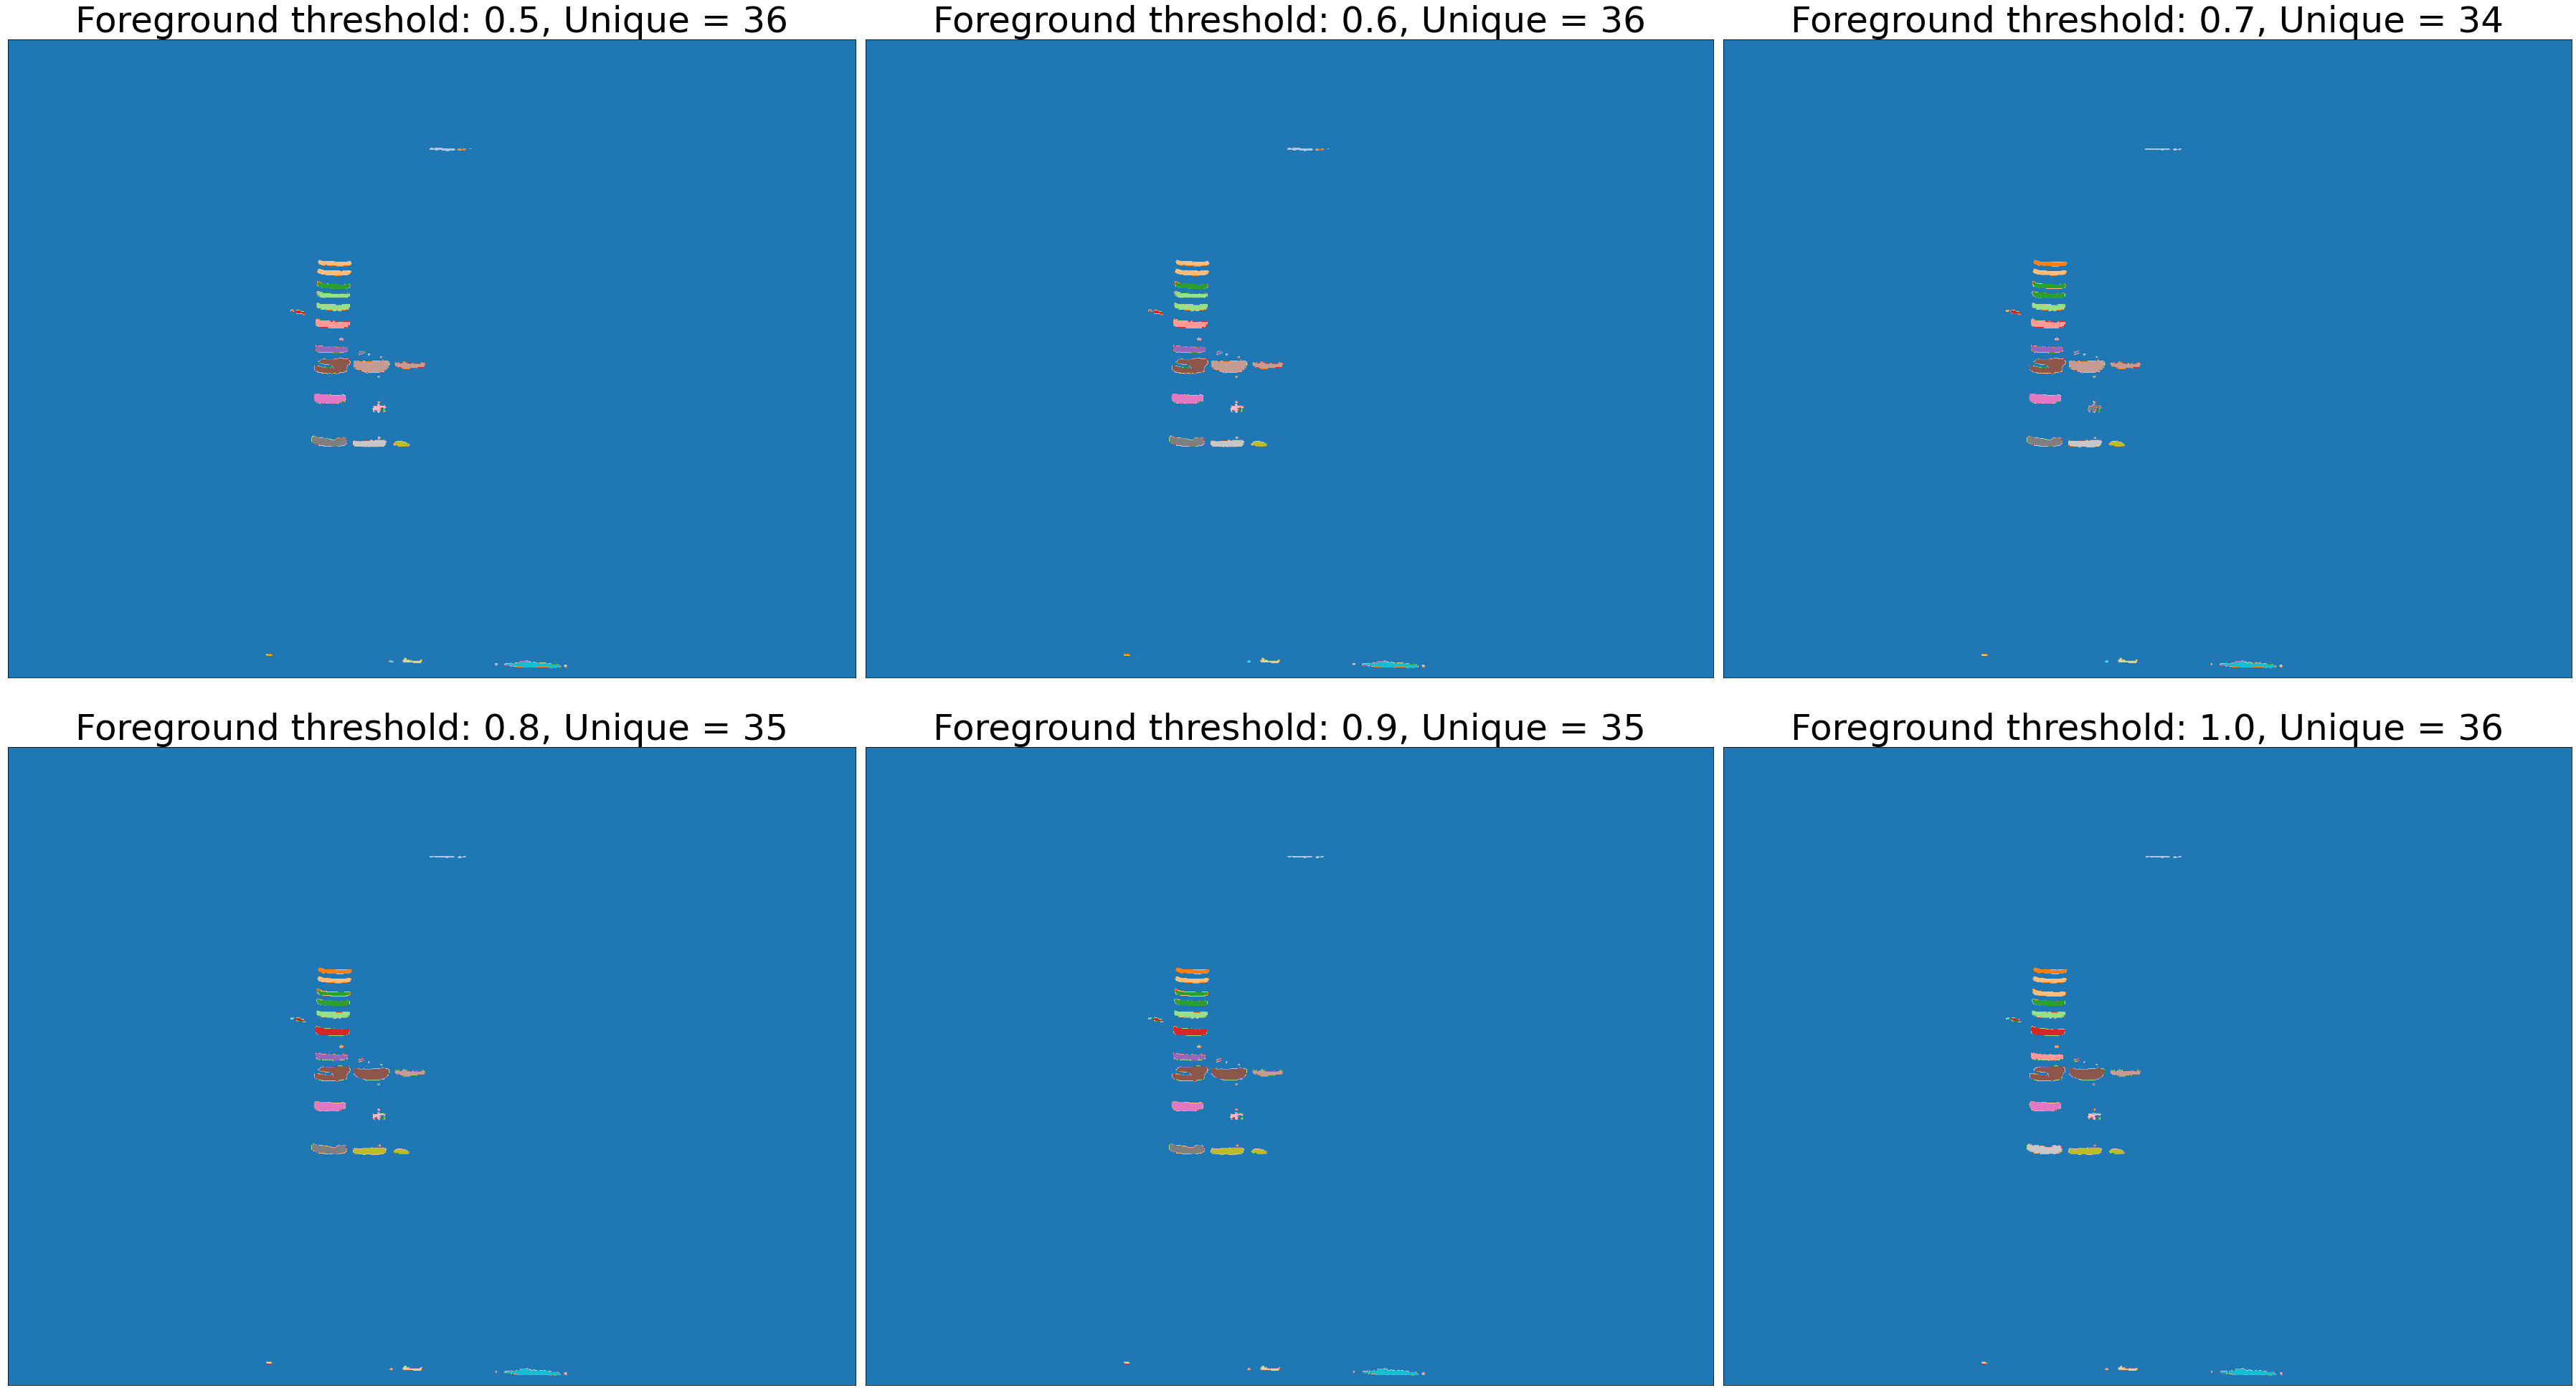

In [112]:
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(50, 30))
for i in range(5, 11):  # 5 - 10
    threshold = i / 10
    thresholded = np.zeros((height, width))
    for row in range(height):
        for column in range(width):
            if data[row][column][0] < (1-threshold) and data[row][column][1] > threshold:
                thresholded[row][column] = 1
    # watershed
    separated = watershed_seg(thresholded, 0.5, 0.5)
    unique = np.unique(separated)[-1]
    
    axs[(i-5)//3][(i-5)%3].imshow(separated, cmap='tab20')
    axs[(i-5)//3][(i-5)%3].set_title(f'Foreground threshold: {threshold}, Unique = {unique}', fontsize=50)
    
    plt.tight_layout()
    plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[])  # remove ticks
    

# Decided Threshold: 0.8

In [121]:
threshold = 0.8
thresholded = np.zeros((height, width))
for row in range(height):
    for column in range(width):
        if data[row][column][0] < (1-threshold) and data[row][column][1] > threshold:
            thresholded[row][column] = 1
# watershed
separated = watershed_seg(thresholded, 0.5, 0.5)
unique = np.unique(separated)

In [177]:
# Get coordinates for each unique band
# create array of intensities
volume_labels = np.empty((len(unique)), float)

In [178]:
selected_image = "C:/2022_Summer_Intern/Gel_Images_UNet_Test/Images_Q1+Q2+selected/UVP01966May222019.jpg"

In [179]:
image = imageio.imread(selected_image)  # 0-255, H, W

C:\Users\s2137314\Anaconda3\envs\gel_env\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  """Entry point for launching an IPython kernel.


In [180]:
image.shape

(1024, 1360, 3)

In [181]:
image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)  # 1 channel

In [182]:
image = image.astype(np.float32) / (255 - 0)  # normalized between 0 and 1

In [183]:
for h in range(height):
    for w in range(width):
        volume_labels[separated[h][w]] += image[h][w]  # index = label, value += intensity(between 0 and 1)

In [184]:
print(volume_labels)

[5.36168208e+05 7.89411789e+00 2.43858831e+02 4.74117665e+01
 1.55294126e+00 7.50517664e+02 8.15364725e+02 9.05611781e+02
 8.69411786e+02 9.03588263e+02 1.33647062e+01 7.76235313e+01
 1.63895295e+03 3.35058835e+01 1.08480002e+03 7.84823545e+01
 1.40588236e+01 1.17647061e+01 2.50015297e+03 2.56034118e+03
 9.16505893e+02 1.00470591e+01 1.08777652e+03 1.44588239e+01
 2.46070596e+02 1.50588242e+01 1.19791769e+03 8.85882381e+00
 8.82305919e+02 2.06411767e+02 2.76352948e+01 1.33800002e+02
 1.26000001e+01 7.32423540e+02 5.63529423e+00 1.25882356e+01]


<BarContainer object of 35 artists>

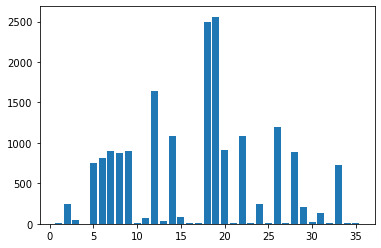

In [186]:
plt.bar(range(1, len(volume_labels)), volume_labels[1:])

In [118]:
print(test_dict)

{'test': ['test', 'test']}


# Test on model gel image

In [270]:
original_image = imageio.imread("C:/Users/s2137314/Downloads/1kbPlus_DNAladder.png")
n_channels = 1

C:\Users\s2137314\Anaconda3\envs\gel_env\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  """Entry point for launching an IPython kernel.


In [271]:
# Converting to desired number of channels
if n_channels == 1:  # Target input: 1 channel
    if original_image.shape[-1] == 3:  # Actual input: 3 channels
        original_image = cv2.cvtColor(original_image, cv2.COLOR_RGB2GRAY)
    elif original_image.shape[-1] == 4: # Actual input: 4 channels
        original_image = cv2.cvtColor(original_image, cv2.COLOR_RGBA2GRAY)
    # No change required for already grayscale images
elif n_channels == 3:  # Target input: 3 channels
    if original_image.shaoe[-1] == 4:  # Actual input: 4 channels
        original_image = cv2.cvtColor(original_image, cv2.COLOR_RGBA2RGB)
    elif original_image.shape[-1] != 3:  # Actual input: 1 channels
        original_image = cv2.cvtColor(original_image, cv2.COLOR_GRAY2RGB)


# Normalizing image
if original_image.dtype == 'uint8':
    max_val = 255
elif original_image.dtype == 'uint16':
    max_val = 65535
original_image = original_image.astype(np.float32) / (max_val - 0)

standard_image_transform = transforms.Compose([transforms.ToTensor()])
original_image_tensor = standard_image_transform(original_image)

In [272]:
original_image_tensor = torch.unsqueeze(original_image_tensor, dim=0)

In [273]:
print(original_image_tensor.shape)

torch.Size([1, 1, 507, 142])


In [274]:
net = UNet(n_channels=1, n_classes=2, bilinear=False)
net.train()
modelweights = torch.load(f="C:/Users/s2137314/Downloads/checkpoint_epoch180.pth", map_location=torch.device("cpu"))
net.load_state_dict(state_dict = modelweights)

<All keys matched successfully>

In [275]:
with torch.no_grad():
    # predict the mask
    mask_pred = net(original_image_tensor)

In [276]:
mask_pred.squeeze()

tensor([[[ 2.6375,  2.5482,  2.7620,  ...,  2.9744,  2.6799,  2.6792],
         [ 2.7677,  2.5112,  2.7237,  ...,  2.5378,  2.0642,  2.5718],
         [ 3.0876,  2.6979,  2.7356,  ...,  1.4854,  1.3696,  2.4223],
         ...,
         [ 3.5168,  3.2291,  3.1748,  ..., -1.2727,  0.1633,  1.8561],
         [ 3.6524,  3.5964,  3.5818,  ...,  1.2286,  1.8433,  2.6644],
         [ 3.4645,  3.6487,  3.5999,  ...,  2.2974,  2.5013,  3.0758]],

        [[-2.0963, -2.1121, -2.2821,  ..., -2.5140, -2.2056, -2.0908],
         [-2.1550, -1.9123, -2.2016,  ..., -2.1183, -1.7034, -2.1050],
         [-2.3914, -2.0310, -2.1795,  ..., -1.2312, -0.6924, -1.8399],
         ...,
         [-2.5838, -2.4088, -2.4167,  ...,  1.7710,  0.6270, -1.1825],
         [-2.7218, -2.6890, -2.7037,  ..., -0.7768, -1.3336, -2.0433],
         [-2.5508, -2.6837, -2.6456,  ..., -1.8127, -1.8627, -2.1130]]])

In [277]:
mask_pred_array = np.transpose(mask_pred.detach().squeeze().cpu().numpy(), (1, 2, 0))  # CHW to HWC

In [278]:
mask_pred_array.shape

(507, 142, 2)

In [279]:
height, width = mask_pred_array.shape[0], mask_pred_array.shape[1]

In [280]:
print(range(height)[-1])

506


In [289]:
threshold = 0.8
thresholded = np.zeros((height, width))
for row in range(height):
    for column in range(width):
        if mask_pred_array[row][column][0] < (1-threshold) and mask_pred_array[row][column][1] > threshold:
            thresholded[row][column] = 1
# watershed
separated = watershed_seg(thresholded, 0.5, 0.5)
unique = np.unique(separated)

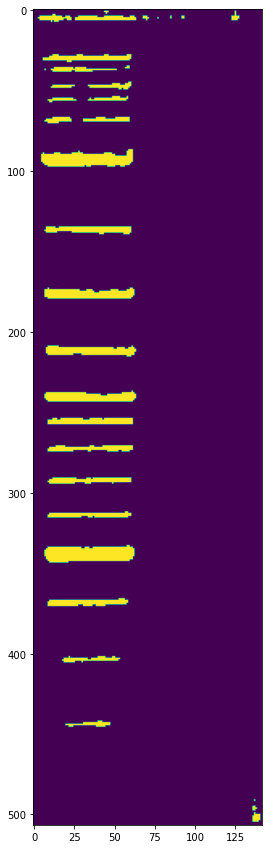

In [302]:
plt.figure(figsize=(10,15))
plt.imshow(thresholded)

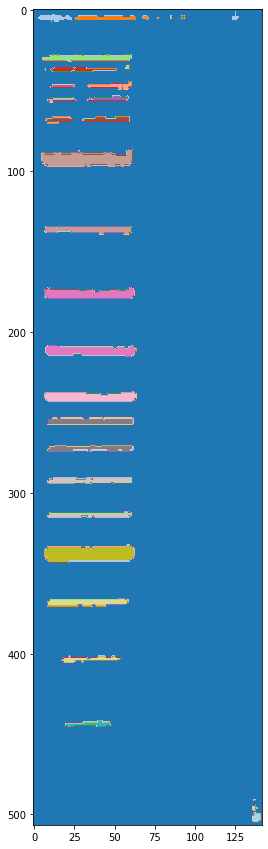

In [294]:
plt.figure(figsize=(10,15))
plt.imshow(separated, cmap='tab20')

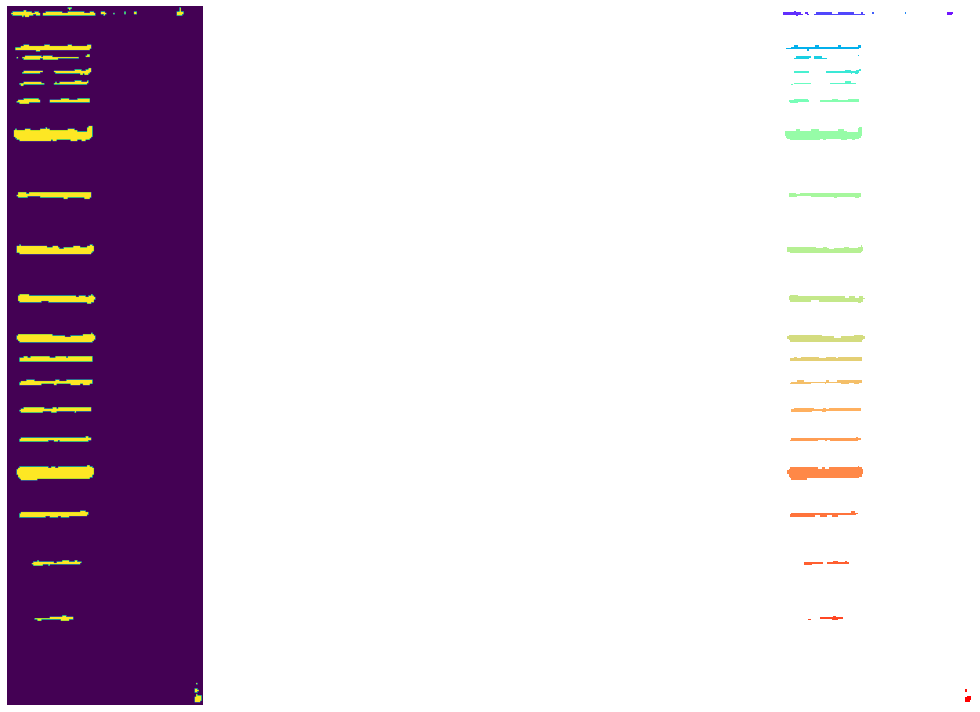

In [321]:
import numpy as np
from scipy import ndimage
from matplotlib import pyplot as plt

# use a boolean condition to find where pixel values are > 0.75
blobs = thresholded == 1

# label connected regions that satisfy this condition
labels, nlabels = ndimage.label(blobs, structure=[[1,1,1],[1,1,1],[1,1,1]])


# find their centres of mass. in this case I'm weighting by the pixel values in
# `img`, but you could also pass the boolean values in `blobs` to compute the
# unweighted centroids.
r, c = np.vstack(ndimage.center_of_mass(thresholded, labels, np.arange(nlabels) + 1)).T

# find their distances from the top-left corner
d = np.sqrt(r*r + c*c)

# plot
fig, ax = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(30, 10))
ax[0].imshow(thresholded)
ax[1].imshow(np.ma.masked_array(labels, ~blobs), cmap=plt.cm.rainbow)
# for ri, ci, di in zip(r, c, d):
#     ax[1].annotate('', xy=(0, 0), xytext=(ci, ri),
#                    arrowprops={'arrowstyle':'<-', 'shrinkA':0})
#     ax[1].annotate('d=%.1f' % di, xy=(ci, ri),  xytext=(0, -5),
#                    textcoords='offset points', ha='center', va='top',
#                    fontsize='x-large')
for aa in ax.flat:
    aa.set_axis_off()
fig.tight_layout()
plt.show()

In [315]:
for h in range(height):
    for w in range(width):
        volume_labels[labels[h][w]] += original_image[h][w]  # index = label, value += intensity(between 0 and 1)

<BarContainer object of 35 artists>

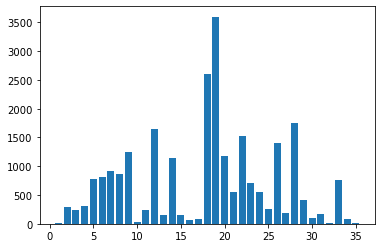

In [316]:
plt.bar(range(1, len(volume_labels)), volume_labels[1:])

In [264]:
volume_labels

array([5.45931443e+05, 1.18941179e+01, 2.60858831e+02, 1.08737257e+02,
       1.04552941e+02, 7.58517664e+02, 8.17364725e+02, 9.09611781e+02,
       8.70411786e+02, 1.01982356e+03, 1.65882358e+01, 1.30286278e+02,
       1.63955687e+03, 7.57451006e+01, 1.10182355e+03, 1.06003924e+02,
       3.10509813e+01, 3.56941181e+01, 2.53586670e+03, 2.90629413e+03,
       1.00343923e+03, 1.93756869e+02, 1.23213338e+03, 2.48756867e+02,
       3.47580403e+02, 9.33254933e+01, 1.26544710e+03, 6.58666680e+01,
       1.17376083e+03, 2.77933337e+02, 5.07725507e+01, 1.48756865e+02,
       1.36000001e+01, 7.39423540e+02, 2.96352942e+01, 1.25882356e+01])

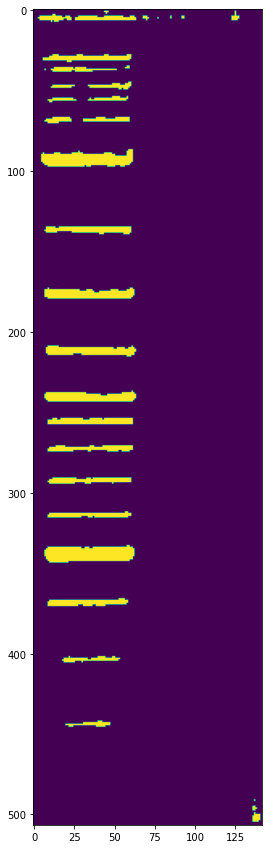

In [268]:
plt.figure(figsize=(10,15))
plt.imshow(thresholded)